In [1]:
import gym
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics
import pandas as pd

In [2]:
def beers_law(solution, path_length, coeffs, min_wavelength, max_wavelength):
    """
    Applys Beers-Lampert Law to get the total absorbtion
    of a solution.
    Inputs:
    solution: Dictionary of the form Name->Concentration
    path_length: float
    coeffs: pd dataframe with column 'Wavelength' and coefficients in other column.
    Each other column corresponds to the coffiecient at that wavelength for the 
    title of the column which should be the same as the solution
    
    'Wavelength', 'Dye1', 'Dye2'
    600, .1, 0
    601, .2, .1

    Returns the overall absorbtion as a float
    """
    wavelengths = []
    spectra = []
    absorbtion = 0
    coeffs_with_index = coeffs.set_index('Wavelength')
    coeffs_with_index.sort_index(inplace=True)
    coeffs_with_index.dropna(inplace=True)
    
    for index, row in coeffs_with_index.iterrows():
        if index >= min_wavelength and index <= max_wavelength:
            for key in solution:
                absorbtion += solution[key] * coeffs_with_index.loc[index, key]
            wavelengths.append(index)
            spectra.append(absorbtion)
            absorbtion = 0
        
    
    return wavelengths, spectra*path_length


def random_solution(coeffs, complexity):
    """
    """
    cont = True
    while cont:
        opt = coeffs.columns[1:]
        solution = {}
        rand = np.random.rand(len(opt))
        for i, name in enumerate(opt):
            if rand[i] > complexity:
                solution[name] = np.random.random() + .01
                
        if len(solution) is not 0:
            cont = False
    
    return solution

def random_spectra(path_length, coeffs, min_wavelength, max_wavelength, complexity):
    """
    """
    
    solution = random_solution(coeffs, complexity)
    #print('goal: ', solution)
    return beers_law(solution, path_length, coeffs, min_wavelength, max_wavelength)

<>:49: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:49: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-2-f78427aa8405>:49: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(solution) is not 0:


In [3]:
class CustomEnv(gym.Env):
  """Custom Environment that follows gym interface"""
  metadata = {'render.modes': ['human']}

  def __init__(self, goal, coeffs, dye_c):
    super(CustomEnv, self).__init__()
    # Define action and observation space
    # They must be gym.spaces objects
    # Example when using discrete actions:
    self.action_space = gym.spaces.Box(low=0.01, high=10, shape=(4,1), dtype=np.float32)
    # Example for using image as input:
    self.observation_space = gym.spaces.Box(low=0, high=5,
                                       shape=(1,len(coeffs)), dtype=np.float32)
    
    
    
    self.sol = {'red': 0, 'green': 0, 'blue': 0}
    self.goal = goal
    self.coeffs = coeffs
    self.total = 0
    self.dye_c = dye_c
    self.iter = 0
    self.prev_sol = {'red': 0, 'green': 0, 'blue': 0}

  def step(self, action):
    new_total = self.total + action[0] + action[1] + action[2] + action[3]

    
    self.sol['red'] = (action[0]) * dye_c['red'] / new_total
    self.sol['green'] = (action[1]) * dye_c['green'] / new_total
    self.sol['blue'] = (action[2])* dye_c['blue'] / new_total
    
    self.total = new_total
    
    
    curr = beers_law(self.sol, 1, self.coeffs, 300, 700)[1]
    prev = beers_law(self.prev_sol, 1, self.coeffs, 300, 700)[1]
    if self.iter % 10 == 0: 
        plt.figure()
        plt.plot(curr, label='curr')
        plt.plot(self.goal, label='goal')
        #plt.plot(prev, label='previous')
        plt.legend()

            
    reward = -sklearn.metrics.mean_squared_error(curr, self.goal) * 10000
    self.iter +=1
    done = True

    
    info = {}
    return curr, reward, done, info


  def reset(self):
    self.prev_sol = self.sol
    self.sol = {'red':0, 'green':0, 'blue':0}
    self.goal = random_spectra(1, self.coeffs, 300, 700, .3)[1]
    #self.iter = 0
    self.total = 0
    
    return self.goal  # reward, done, info can't be included
  def render(self, mode='human'):
    pass
  def close (self):
    pass

  def get_color(self, i):
    i = np.rint(i)
    if i == -1:
        return 'red'
    elif i == 0:
        return 'green'
    elif i == 1:
        return 'blue'

In [4]:
coeff = pd.read_csv('beers_law/rgb_coeff')
coeff.drop(labels='Unnamed: 0', axis=1, inplace=True)
spectra = random_spectra(1, coeff, 300, 700, .3)
#sol = {'red': 0.018302364642095552, 'green': 0.29235102088170106, 'blue': 0.6960934200658536}
#spectra = beers_law(sol, 1, coeff, 300, 700)
dye_c = {'red': 5, 'blue': 5, 'green': 5}
env = CustomEnv(spectra[1], coeff, dye_c)

In [5]:
print(env.observation_space.sample())
print(env.action_space.sample())

[[3.4081326  2.4230044  4.3858776  0.3719013  4.848583   4.4502015
  0.76173395 3.007563   3.2905872  1.5127524  3.724231   3.4521227
  4.8200192  2.502092   3.5528347  1.4040056  3.0928752  4.5539556
  0.7760609  1.3702261  4.8068132  2.4214613  2.3982484  4.141153
  4.4788237  4.074406   0.9549225  1.8501577  0.67218035 4.932318
  3.1843262  3.0741167  2.945498   3.6734376  4.402724   3.9264488
  0.6114034  2.2419662  3.127188   3.2709143  3.252516   4.9816513
  3.8366277  1.5775828  1.0213512 ]]
[[0.7606975]
 [8.893724 ]
 [7.8840623]
 [5.530094 ]]


In [6]:
num_states = 41
num_actions = 4

upper_bound_amount = 10
lower_bound_amount = 0.01

In [7]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [8]:
class Buffer:
    def __init__(self, batch_size=8):
        self.buffer = pd.DataFrame(columns = ['state', 'action', 'reward', 'next_state'])
        self.batch_size = batch_size

    def record(self, obs_tuple):
        self.buffer = self.buffer.append({
            'state': obs_tuple[0],
            'action': obs_tuple[1],
            'reward': obs_tuple[2],
            'next_state': obs_tuple[3]
            
        }, ignore_index=True)
        if len(self.buffer) > self.batch_size:
            self.buffer.drop(index=0, inplace=True)
            self.buffer.reset_index(drop=True, inplace=True)


    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def update(self, state_batch, action_batch, reward_batch, next_state_batch): 
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            tc = target_critic(
                [next_state_batch, target_actions], training=True
            )

            
            y = reward_batch
            critic_value = critic_model([state_batch, action_batch], training=True)
            #tf.print(critic_value)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))



        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )
        
        with tf.GradientTape() as tape:
            #tape.watch(reward_batch)
            actions = actor_model(state_batch, training=True)
            #tf.print(actions)
            critic_value = critic_model([state_batch, actions], training=True)
            #tf.print(critic_value)
            
            
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -critic_value
            print(actor_loss)
            
            
            new = tf.reshape(-reward_batch, [tf.size(reward_batch), 1])
            #tape.watch(new)
            actor_loss = new
            tape.watch(actor_loss)
            print(new)
            #actor_loss = new
            #actor_loss = -tf.math.reduce_mean(reward_batch)
            #tf.print(actor_loss)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )
        return actor_loss, critic_loss

    # We compute the loss and update parameters
    def learn(self):
        # Convert to tensors
        state_batch = self.buffer['state']
        action_batch = self.buffer['action']
        reward_batch = self.buffer['reward']
        next_state_batch = self.buffer['next_state']
        
        
        state_batch = tf.convert_to_tensor(self.buffer['state'].tolist())
        action_batch = tf.convert_to_tensor(self.buffer['action'].tolist())
        reward_batch = tf.convert_to_tensor(self.buffer['reward'].tolist())
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.buffer['next_state'].tolist())


        return self.update(state_batch, action_batch, reward_batch, next_state_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

In [9]:
def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer()
    #last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states))
    out = layers.Dense(32, activation="relu")(inputs)
    out = layers.Dense(16, activation="relu")(out)
    outputs = layers.Dense(4, activation="sigmoid", kernel_initializer=last_init)(out)

    # Our upper bound is 2.0 for Pendulum.
    outputs = outputs * upper_bound_amount
    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(32, activation="relu")(state_input)
    state_out = layers.Dense(16, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(16, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(64, activation="relu")(concat)
    out = layers.Dense(16, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

In [10]:
def policy(state, noise_object):
    #print(state)
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise

    # We make sure action is within bounds
    amount_red = np.clip(sampled_actions[0], lower_bound_amount, upper_bound_amount)
    amount_green = np.clip(sampled_actions[1], lower_bound_amount, upper_bound_amount)
    amount_blue = np.clip(sampled_actions[2], lower_bound_amount, upper_bound_amount)
    amount_water = np.clip(sampled_actions[3], lower_bound_amount, upper_bound_amount)
    #print(sampled_actions)
    #print('sampled actions')
    print([amount_red, amount_green, amount_blue, amount_water])

    return [amount_red, amount_green, amount_blue, amount_water]

In [11]:
std_dev = .05
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 1
actor_lr = 1

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 200
# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.005

buffer = Buffer(8)


[5.114514222046247, 5.058348050018659, 5.064844479462018, 4.958132614990583]
Tensor("Neg:0", shape=(1, 1), dtype=float32)
Tensor("Reshape:0", shape=(1, 1), dtype=float32)


ValueError: in user code:

    <ipython-input-8-17b1398a00c6>:69 update  *
        actor_optimizer.apply_gradients(
    /Users/Will/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:598 apply_gradients  **
        grads_and_vars = optimizer_utils.filter_empty_gradients(grads_and_vars)
    /Users/Will/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/utils.py:78 filter_empty_gradients
        raise ValueError("No gradients provided for any variable: %s." %

    ValueError: No gradients provided for any variable: ['dense/kernel:0', 'dense/bias:0', 'dense_1/kernel:0', 'dense_1/bias:0', 'dense_2/kernel:0', 'dense_2/bias:0'].


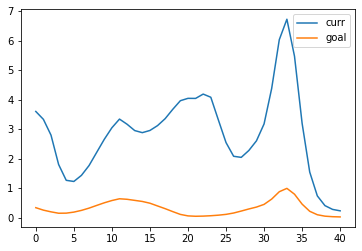

In [12]:
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []
actor_loss_list = []
critic_loss_list = []

# Takes about 4 min to train
for ep in range(total_episodes):

    prev_state = env.reset()
    episodic_reward = 0

    while True:
        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

        action = policy(tf_prev_state, ou_noise)
        # Recieve state and reward from environment.
        state, reward, done, info = env.step(action)


        obs_tuple = (prev_state, action, reward, state)
        buffer.record(obs_tuple)
        episodic_reward += reward


        x, y = buffer.learn()
        actor_loss_list.append(x.numpy())
        critic_loss_list.append(y)
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)

        # End this episode when `done` is True
        if done:
            break

        prev_state = state

    ep_reward_list.append(episodic_reward)
    # Mean of last 40 episodes
    avg_reward = np.mean(ep_reward_list[-40:])
    #print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    avg_reward_list.append(avg_reward)

# Plotting graph
# Episodes versus Avg. Rewards
plt.figure()
plt.plot(ep_reward_list)
plt.xlabel("Episode")
plt.ylabel("Epsiodic Reward")
plt.show()
plt.figure()
#print(actor_loss_list)
#print(critic_loss_list)
#plt.plot(actor_loss_list)
plt.xlabel("Episode")
plt.ylabel("Actor Loss")
plt.figure()
plt.plot(critic_loss_list)
plt.xlabel("Episode")
plt.ylabel("Critic Loss")